# Расчет цены на автомобиль
### Книга 05 - подстройка и выбор моделей

Постановка задачи:
Необходимо разработать модель, которая бы рассчитывала цену на выставленный на продажу автомобиль.  По условиям учебной задачи обучающих данных в явном виде не предоставлено. Только тестовые, собранные на авто-ру больше года назад. Необходимо самостоятельно разработать программу, которая бы собирала данные по объявлениям на том же сайте авто.ру. Дополнительная сложность - количество данных. Оцениваться работа будет по порядка 35к записей. Необходимо собрать порядка 140 тыс записей.  На самом сайте автору сейчас актуально порядка 90к объявлений.

Краткие итоги предыдущей работы:
- С сайта авто.ру загружен набор предложений по 12 брендам автомобилей (как в тестовом наборе), размером порядка 42к записей.
- Корректировка инфляции показала что эффективнее всего просто домножать результат текущего прогнозирования цен на мультипликатор. Текущее значение мультипликатора 0.72
- Признаки подгружены из внешнего файла и созданы на основе существующих.
- В ходе экспериментов целевое колидование высококардинальных признаков оказалось предпочтительным.

Ближайший план работы:
- Повторить и проверить достигнутый результат.
- Попробовать модель CatBust от Яндекса, разработанную для высококардинальных задач.
- Подобрать гиперпараметры для моделей.
- Попробовать стэкинг моделей.
- Выбрать итоговую модель, сформулировать выводы и завершить работу над проектом.




In [77]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

import P05_01_lib as p05 # Модули с предыдущих рабочих листов в виде отдельной библиотеки
RANDOM_SEED = 42

### Краткое содержание предыдущих действий

Слияние двух наборов


In [2]:
train = pd.read_csv('input/211121-12brands.csv')
train.drop(['Unnamed: 0'], axis=1, inplace=True)
train['train'] = 1
test = pd.read_csv('input/test.csv')

In [3]:
test['price'] = 0.0
test['train'] = 0
df = pd.concat([test, train], join='inner', ignore_index=True)
df = p05.initial_transformation(df)
df.head()

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,manuf_year,sell_id,transmission,num_owners,gear,price,train,body_type,orig_license,left_steering
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105.0,B,74000.0,2013,OCTAVIA,...,2014,1100575026,AMT,3,FWD,0,0,f_back,1,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110.0,B,60563.0,2017,OCTAVIA,...,2017,1100549428,MT,1,FWD,0,0,f_back,1,1
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152.0,B,88000.0,2013,SUPERB,...,2014,1100658222,AMT,1,FWD,0,0,f_back,1,1
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110.0,B,95000.0,2013,OCTAVIA,...,2014,1100937408,AT,1,FWD,0,0,f_back,1,1
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152.0,B,58536.0,2008,OCTAVIA,...,2012,1101037972,AT,1,FWD,0,0,f_back,1,1


Обогащение внешними данными и разработка новых признаков

In [4]:
car_models = pd.read_csv('input/CarModels.csv')
car_models.head()

,brand,model,eur_size,type,segment,geo
0,AUDI,100,E,Car,Prem,EUR
1,AUDI,200,E,Car,Prem,EUR
2,AUDI,80,D,Car,Prem,EUR
3,AUDI,90,D,Car,Prem,EUR
4,AUDI,920,D,Car,Prem,EUR


In [5]:
df = p05.add_external_features(df, car_models)
df.head()

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,gear,price,train,body_type,orig_license,left_steering,size_cat,sport_car,euro_car,premium
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105.0,B,74000.0,2013,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110.0,B,60563.0,2017,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152.0,B,88000.0,2013,SUPERB,...,FWD,0,0,f_back,1,1,4,0,1,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110.0,B,95000.0,2013,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152.0,B,58536.0,2008,OCTAVIA,...,FWD,0,0,f_back,1,1,3,0,1,0


In [6]:
df = p05.engineer_features(df)

Кодирование категориальных признаков

In [7]:
low_card_cat, df = p05.encode_low_card_categories(df)
high_card_cat, df = p05.encode_high_card_catrgories(df)
df.head()

,body,brand,url,color,displacement,power,fuel,mileage,model_year,model,...,gear_RWD,body_type_MPV,body_type_SUV,body_type_coupe,body_type_f_back,body_type_sedan,body_type_wagon,brand_tgt,color_tgt,model_tgt
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105.0,B,74000.0,2013,OCTAVIA,...,0,0,0,0,1,0,0,-0.221593,0.230733,-0.060526
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110.0,B,60563.0,2017,OCTAVIA,...,0,0,0,0,1,0,0,-0.221593,0.566096,-0.060526
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152.0,B,88000.0,2013,SUPERB,...,0,0,0,0,1,0,0,-0.221593,0.325289,0.276302
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110.0,B,95000.0,2013,OCTAVIA,...,0,0,0,0,1,0,0,-0.221593,0.367085,-0.060526
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152.0,B,58536.0,2008,OCTAVIA,...,0,0,0,0,1,0,0,-0.221593,0.444131,-0.060526


In [8]:
df.columns

Index(['body', 'brand', 'url', 'color', 'displacement', 'power', 'fuel',
       'mileage', 'model_year', 'model', 'doors', 'manuf_year', 'sell_id',
       'transmission', 'num_owners', 'gear', 'price', 'train', 'body_type',
       'orig_license', 'left_steering', 'size_cat', 'sport_car', 'euro_car',
       'premium', 'age', 'ann_mil', 'intensity', 'power_size', 'vol_power',
       'fuel_B', 'fuel_D', 'fuel_E', 'fuel_G', 'fuel_H', 'transmission_AMT',
       'transmission_AT', 'transmission_CVT', 'transmission_MT', 'gear_AWD',
       'gear_FWD', 'gear_RWD', 'body_type_MPV', 'body_type_SUV',
       'body_type_coupe', 'body_type_f_back', 'body_type_sedan',
       'body_type_wagon', 'brand_tgt', 'color_tgt', 'model_tgt'],
      dtype='object')

In [9]:
print(low_card_cat); print(high_card_cat)

['fuel_B', 'fuel_D', 'fuel_E', 'fuel_G', 'fuel_H', 'transmission_AMT', 'transmission_AT', 'transmission_CVT', 'transmission_MT', 'gear_AWD', 'gear_FWD', 'gear_RWD', 'body_type_MPV', 'body_type_SUV', 'body_type_coupe', 'body_type_f_back', 'body_type_sedan', 'body_type_wagon']
['brand_tgt', 'color_tgt', 'model_tgt']


In [56]:
# cat_cols = ['brand', 'color', 'fuel', 'model', 'transmission',  'gear', 'body_type']
dig_cat = ['euro_car', 'premium', 'orig_license','left_steering','num_owners', 'doors', 'intensity', 'sport_car', 'size_cat'  ]
num_cols = [ 'power', 'mileage', 'age', 'ann_mil',  'vol_power', 'power_size' ]
target = ['price']

In [60]:
model_cols = num_cols + low_card_cat + dig_cat + high_card_cat; print('Model Columns:', model_cols, '\n')
cols2drop =  [x for x in all_cols if x not in model_cols + ['sell_id', 'price']]; print('Columns 2 drop', cols2drop)

Model Columns: ['power', 'mileage', 'age', 'ann_mil', 'vol_power', 'power_size', 'fuel_B', 'fuel_D', 'fuel_E', 'fuel_G', 'fuel_H', 'transmission_AMT', 'transmission_AT', 'transmission_CVT', 'transmission_MT', 'gear_AWD', 'gear_FWD', 'gear_RWD', 'body_type_MPV', 'body_type_SUV', 'body_type_coupe', 'body_type_f_back', 'body_type_sedan', 'body_type_wagon', 'euro_car', 'premium', 'orig_license', 'left_steering', 'num_owners', 'doors', 'intensity', 'sport_car', 'size_cat', 'brand_tgt', 'color_tgt', 'model_tgt'] 

Columns 2 drop ['body', 'brand', 'url', 'color', 'displacement', 'fuel', 'model_year', 'model', 'manuf_year', 'transmission', 'gear', 'train', 'body_type']


Подготовка данных для переноса в Colab выявила ошибку в признаках. Были разработаны два признака, однако они были потеряны. Надо чаще перепроверять состав признаков.

In [11]:
# p05 = reload(p05)

In [61]:

p05.eval_data(df.query('train==1')[model_cols], df.query('train==1').price , 'CE02')

Eval: ExtEns GradBst RanFrst done. 374.9065 sec


ExtEns     11.630973
GradBst    11.800238
RanFrst    11.492993
Name: CE02, dtype: float64

Результаты предыдущей рабочей книги сохранены. После добавления потерянных признаков они слугка улудшились.

In [88]:
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
rfr.fit( df.query('train==1')[model_cols].to_numpy(), np.log(df.query('train==1').price.to_numpy()))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211203_subm_01.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.936138e+05
1,1100549428,1.011234e+06
2,1100658222,1.157390e+06
3,1100937408,8.028243e+05
4,1101037972,6.834991e+05


Kaggle Score 16.10608 улучшены по сравнению с предыдущим 16.1782.  Хорошо, что потерянные признаки нашлись. Необходимо быть внимательнее.

###  Настройка гиперпараметров одиночных моделей

#### Настройка гиперпараметров случайного леса

Настройку гиперпараметров начну с самой простой модели - случайного леса.  Алгоритм подбора позаимствован из статьи А.Чена (https://habr.com/ru/company/ruvds/blog/488342/). Однако я решил не делать полный перебор, а сделать несколько серий экспериментов со случайным набором параметров, постепенно сужая рамки.

In [22]:
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['log2', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)] }
rs = RandomizedSearchCV(RandomForestRegressor(), param_dist, scoring='neg_mean_absolute_error', n_iter = 100, cv = 3, verbose = 1, n_jobs=-1, random_state=RANDOM_SEED)
rs.fit(X, np.log(y))
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 100,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 15}

In [23]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([ 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_test_score'], axis=1)
rs_df.head(5)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,mean_test_score,rank_test_score
0,100,12,2,log2,15,-0.151201,1
1,500,28,2,log2,14,-0.155701,2
2,900,7,7,log2,13,-0.160060,3
3,300,18,7,sqrt,14,-0.160206,4
4,900,7,7,log2,12,-0.162118,5
5,300,23,2,sqrt,11,-0.162675,6
6,400,18,12,log2,13,-0.165981,7
7,800,12,12,log2,11,-0.170140,8
8,900,7,7,sqrt,10,-0.170806,9
9,300,44,18,log2,14,-0.171299,10


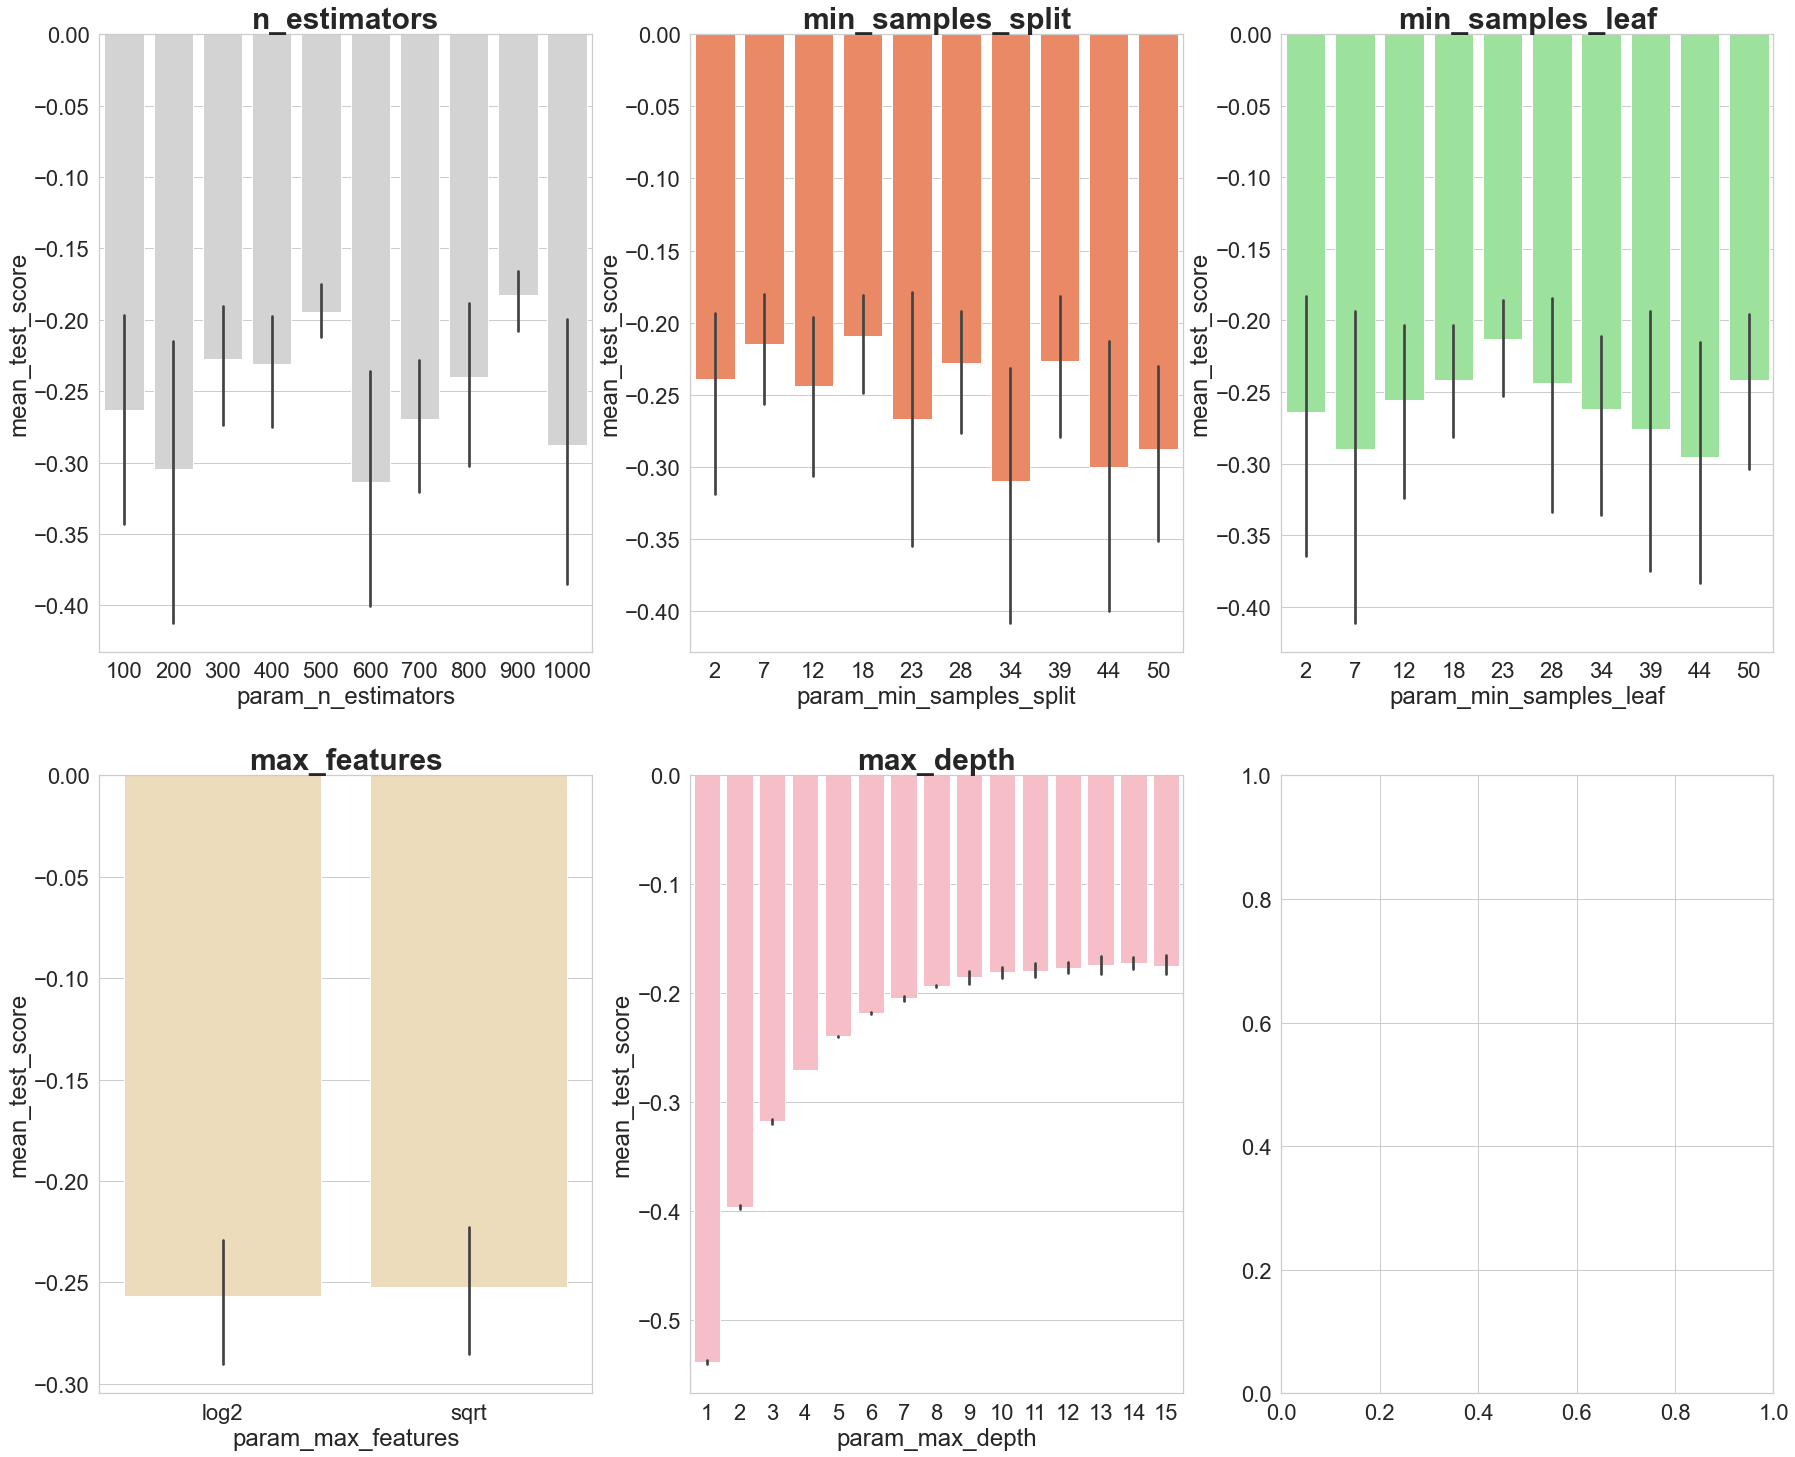

In [25]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
#axs[0,0].set_ylim([.60,.99])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
# axs[0,1].set_ylim([.60,.99])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
# axs[0,2].set_ylim([.60,.99])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
# axs[1,0].set_ylim([.60,.99])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
# axs[1,1].set_ylim([.40,.99])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
# sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
# axs[1,2].set_ylim([.88,.92])
# axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show();

In [32]:
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)],
              'max_features': ['sqrt'],
              'max_depth': [int(x) for x in np.linspace(start = 15, stop = 15, num = 1)],
              'min_samples_split': [int(x) for x in np.linspace(start = 3, stop = 12, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 3, stop = 12, num = 10)] }
rs = RandomizedSearchCV(RandomForestRegressor(), param_dist, scoring='neg_mean_absolute_error', n_iter = 100, cv = 3, verbose = 1, n_jobs=-1, random_state=RANDOM_SEED)
rs.fit(X, np.log(y))
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 15}

In [33]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([ 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_test_score'], axis=1)
rs_df.head(5)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,mean_test_score,rank_test_score
0,300,4,3,sqrt,15,-0.150583,1
1,200,6,3,sqrt,15,-0.150695,2
2,200,5,3,sqrt,15,-0.150975,3
3,300,8,3,sqrt,15,-0.151108,4
4,100,6,3,sqrt,15,-0.151399,5


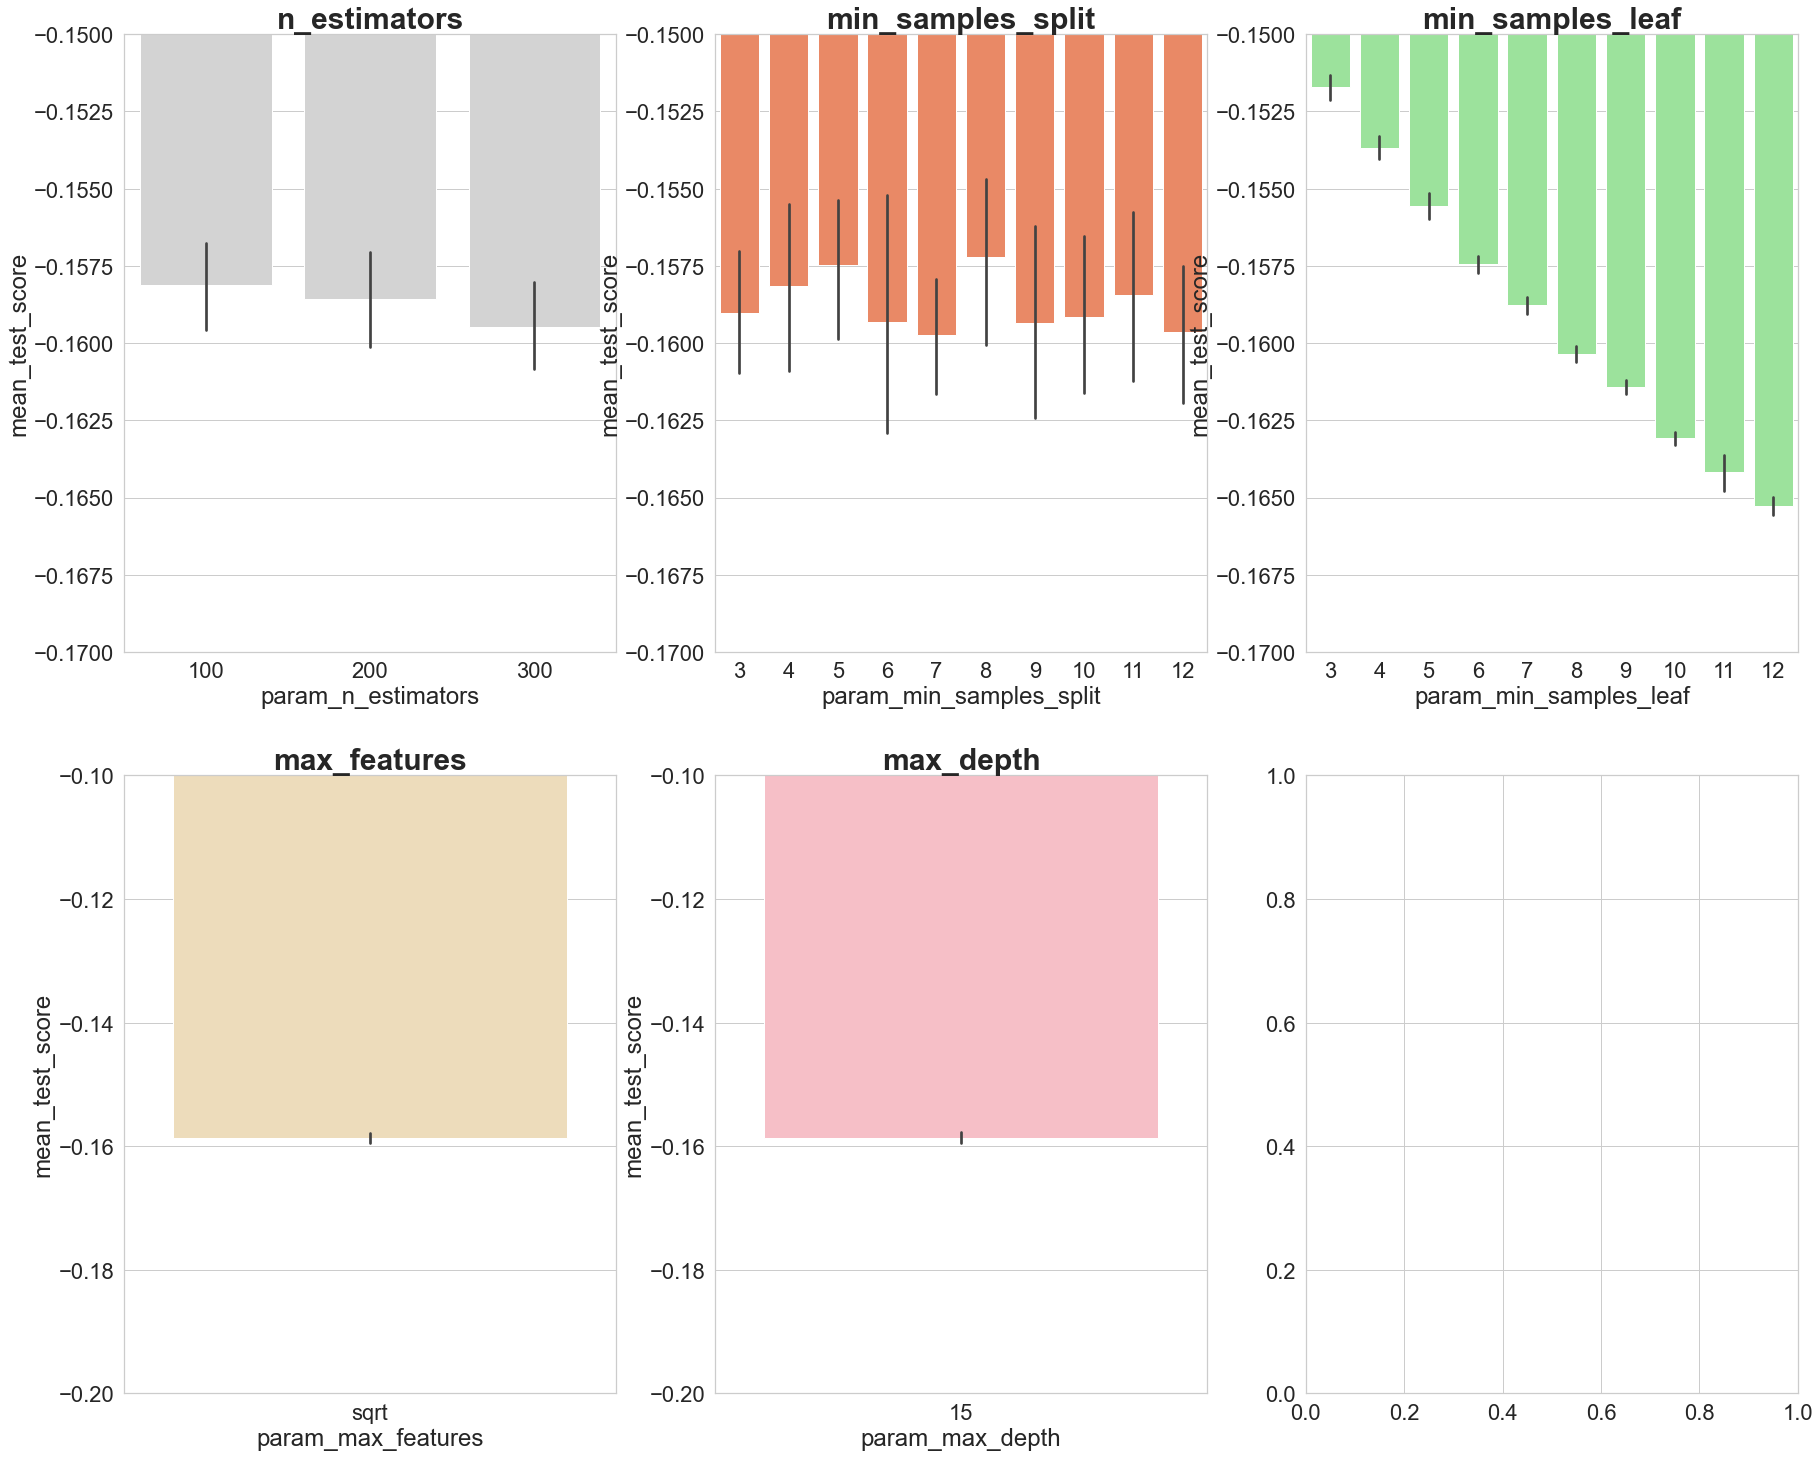

In [37]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([-.17,-.15])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([-.17,-.15])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([-.17,-.15])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([-.2,-.1])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([-.20,-.1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
# sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
# axs[1,2].set_ylim([.88,.92])
# axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show();

In [38]:
p05 = reload(p05)

Функция для тестирования доработана - в библиотеке сформирована отдельная функция для тестирования ML модели на кросс-валидации. Теперь можно посчитать одну модель на кроссвалидации из 5 складок.  Попробую найденные параметры сначала на обучающей выборке.

In [40]:
p05.eval_model(df.query('train==1')[model_cols],
               df.query('train==1').price,
               RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_SEED, max_depth=15,min_samples_split=5))

Eval: done. 16.2996 sec


11.482998686517847

Результат впечатляет, а как будет при оценке качества на Kaggle

In [41]:
rfr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1, max_depth=15, min_samples_split=5)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
rfr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_19.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.932170e+05
1,1100549428,1.029373e+06
2,1100658222,1.114323e+06
3,1100937408,8.045775e+05
4,1101037972,6.904031e+05


Kaggle Score с потерей признаков был 16.1849. Это чуточку хуже ранее достигнутого результата 16.1782.  Возможно, имеет место переобучение под обучающую выборку и лучше использовать параметры по умолчанию.
Еще раз проверю это с добавленными признаками.

In [64]:
rfr = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1,  min_samples_split=5)
rfr.fit(df.query('train==1')[model_cols].to_numpy(), np.log(df.query('train==1').price.to_numpy()))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(rfr.predict(Xt))*0.72
subm.to_csv('./submissions/211203_subm_02.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.931506e+05
1,1100549428,1.017692e+06
2,1100658222,1.134927e+06
3,1100937408,8.030730e+05
4,1101037972,6.836697e+05


Kaggle Score 16.04280 Интуитивное предположение об отказе от ограничения глубины и увеличении леса принесло результаты.

#### Регрессор CatBoost

Есть желание попробовать эту ML модель от Яндекса с учетом неизрасходованных (на момент работы над проектом) попыток оценки качества на Kaggle.

In [44]:
cbr = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', custom_metric=['R2', 'MAE'],  silent=True, )

p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, cbr)

Eval: done. 117.2664 sec


11.068605593396803

In [45]:
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
cbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(cbr.predict(Xt))*0.72
subm.to_csv('./submissions/211202_subm_20.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.897620e+05
1,1100549428,9.480818e+05
2,1100658222,1.005983e+06
3,1100937408,7.609700e+05
4,1101037972,7.526950e+05


Kaggle Score 14.62568  Впечатляющий результат обучающей выборки повторен.


In [66]:
cbr = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', custom_metric=['R2', 'MAE'],  silent=True, )
cbr.fit(df.query('train==1')[model_cols].to_numpy(),np.log(df.query('train==1').price.to_numpy()))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(cbr.predict(Xt))*0.72
subm.to_csv('./submissions/211203_subm_03.csv', index=False)
subm.head()

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

,sell_id,price
0,1100575026,6.822458e+05
1,1100549428,9.309028e+05
2,1100658222,1.017226e+06
3,1100937408,7.583119e+05
4,1101037972,7.523123e+05


Kaggle Score 14.59794  Впечатляющий результат еще несколько улучшен за счет потерянных признаков.  Похоже что приближаюсь к минимуму.


#### Подбор гиперпараметров для GradBoosting

In [48]:
for md in [3,5,7,9,11]:
    for nest in [1000,2000]:
        gbr = GradientBoostingRegressor(n_estimators=nest, max_depth= md,  random_state=RANDOM_SEED, verbose=0)
        mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, gbr)
        print('max_depth=',md,'n_estimators=',nest, 'MAPE: {:.4f}'.format(mape_sc))

Eval: done. 307.3843 sec
max_depth= 3 n_estimators= 1000 MAPE: 11.8280
Eval: done. 618.9549 sec
max_depth= 3 n_estimators= 2000 MAPE: 11.5166
Eval: done. 493.0595 sec
max_depth= 5 n_estimators= 1000 MAPE: 11.2894
Eval: done. 987.9490 sec
max_depth= 5 n_estimators= 2000 MAPE: 11.3245
Eval: done. 677.5776 sec
max_depth= 7 n_estimators= 1000 MAPE: 11.3065
Eval: done. 1376.8501 sec
max_depth= 7 n_estimators= 2000 MAPE: 11.4325
Eval: done. 853.9868 sec
max_depth= 9 n_estimators= 1000 MAPE: 11.4609
Eval: done. 1717.6816 sec
max_depth= 9 n_estimators= 2000 MAPE: 11.5321
Eval: done. 1018.5813 sec
max_depth= 11 n_estimators= 1000 MAPE: 11.7222
Eval: done. 2035.8395 sec
max_depth= 11 n_estimators= 2000 MAPE: 11.7382


In [49]:
for md in [4,6]:
    for nest in [1000,2000]:
        gbr = GradientBoostingRegressor(n_estimators=nest, max_depth= md,  random_state=RANDOM_SEED, verbose=0)
        mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, gbr)
        print('max_depth=',md,'n_estimators=',nest, 'MAPE: {:.4f}'.format(mape_sc))

Eval: done. 405.8477 sec
max_depth= 4 n_estimators= 1000 MAPE: 11.4141
Eval: done. 813.4563 sec
max_depth= 4 n_estimators= 2000 MAPE: 11.3428
Eval: done. 586.1385 sec
max_depth= 6 n_estimators= 1000 MAPE: 11.2580
Eval: done. 1171.6807 sec
max_depth= 6 n_estimators= 2000 MAPE: 11.3562


Наиболее оптимальными параметрами для GradBoosting выглядят 1000 деревьев с глубиной до 6.

In [50]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth= 6,  random_state=RANDOM_SEED, verbose=0)
X = df.query('train==1')[model_cols].to_numpy()
y = df.query('train==1').price.to_numpy()
gbr.fit(X,np.log(y))
Xt = df.query('train==0')[model_cols].to_numpy()
subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(gbr.predict(Xt))*0.72
subm.to_csv('./submissions/211203_subm_00.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.412401e+05
1,1100549428,9.592852e+05
2,1100658222,1.037812e+06
3,1100937408,7.828596e+05
4,1101037972,7.255373e+05


Kaggle Score 15.17254  Незначительное улучшение результата, вероятно переобучение на обучающих данных.

#### Подбор гиперпараметров для ExtraTrees

Цель - выбрать наилучшую модель для стэкинга с другими моделями.

In [73]:
for msf in [1,3,5]:
    for nest in [100, 200]:
        etr = ExtraTreesRegressor(n_estimators=nest, min_samples_leaf=msf, n_jobs=-1, random_state = RANDOM_SEED)
        mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, etr)
        print('min_samples_leaf=',msf,'n_estimators=',nest, 'MAPE: {:.4f}'.format(mape_sc))

Eval: done. 16.8836 sec
min_samples_leaf= 1 n_estimators= 100 MAPE: 11.6310
Eval: done. 47.3192 sec
min_samples_leaf= 1 n_estimators= 200 MAPE: 11.5935
Eval: done. 17.0470 sec
min_samples_leaf= 3 n_estimators= 100 MAPE: 11.1544
Eval: done. 31.1543 sec
min_samples_leaf= 3 n_estimators= 200 MAPE: 11.1373
Eval: done. 14.9840 sec
min_samples_leaf= 5 n_estimators= 100 MAPE: 11.2042
Eval: done. 30.2925 sec
min_samples_leaf= 5 n_estimators= 200 MAPE: 11.1860


In [75]:
for msf in [2,4]:
    for nest in [100, 200]:
        etr = ExtraTreesRegressor(n_estimators=nest, min_samples_leaf=msf, n_jobs=-1, random_state = RANDOM_SEED)
        mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, etr)
        print('min_samples_leaf=',msf,'n_estimators=',nest, 'MAPE: {:.4f}'.format(mape_sc))

Eval: done. 23.7291 sec
min_samples_leaf= 2 n_estimators= 100 MAPE: 11.2450
Eval: done. 47.9182 sec
min_samples_leaf= 2 n_estimators= 200 MAPE: 11.2309
Eval: done. 15.7134 sec
min_samples_leaf= 4 n_estimators= 100 MAPE: 11.1484
Eval: done. 32.2919 sec
min_samples_leaf= 4 n_estimators= 200 MAPE: 11.1371


In [76]:
for msf in [3,4]:
    for nest in [200, 300, 400, 500]:
        etr = ExtraTreesRegressor(n_estimators=nest, min_samples_leaf=msf, n_jobs=-1, random_state = RANDOM_SEED)
        mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, etr)
        print('min_samples_leaf=',msf,'n_estimators=',nest, 'MAPE: {:.4f}'.format(mape_sc))

Eval: done. 29.1870 sec
min_samples_leaf= 3 n_estimators= 200 MAPE: 11.1373
Eval: done. 46.5187 sec
min_samples_leaf= 3 n_estimators= 300 MAPE: 11.1275
Eval: done. 59.1336 sec
min_samples_leaf= 3 n_estimators= 400 MAPE: 11.1272
Eval: done. 77.1473 sec
min_samples_leaf= 3 n_estimators= 500 MAPE: 11.1283
Eval: done. 29.6816 sec
min_samples_leaf= 4 n_estimators= 200 MAPE: 11.1371
Eval: done. 43.2470 sec
min_samples_leaf= 4 n_estimators= 300 MAPE: 11.1340
Eval: done. 58.3112 sec
min_samples_leaf= 4 n_estimators= 400 MAPE: 11.1328
Eval: done. 73.0513 sec
min_samples_leaf= 4 n_estimators= 500 MAPE: 11.1298


Наиболее предпочтительными параметрами для модели выглядят min_samples_leaf = 3 и n_estimators = 400.

### Исследования моделей на Google Colab

Попробую подготовить данные для GoogleColab.

In [67]:
all_cols = list(df.columns); print(all_cols)

['body', 'brand', 'url', 'color', 'displacement', 'power', 'fuel', 'mileage', 'model_year', 'model', 'doors', 'manuf_year', 'sell_id', 'transmission', 'num_owners', 'gear', 'price', 'train', 'body_type', 'orig_license', 'left_steering', 'size_cat', 'sport_car', 'euro_car', 'premium', 'age', 'ann_mil', 'intensity', 'power_size', 'vol_power', 'fuel_B', 'fuel_D', 'fuel_E', 'fuel_G', 'fuel_H', 'transmission_AMT', 'transmission_AT', 'transmission_CVT', 'transmission_MT', 'gear_AWD', 'gear_FWD', 'gear_RWD', 'body_type_MPV', 'body_type_SUV', 'body_type_coupe', 'body_type_f_back', 'body_type_sedan', 'body_type_wagon', 'brand_tgt', 'color_tgt', 'model_tgt']


In [71]:
cols2drop =  [x for x in all_cols if x not in model_cols + ['sell_id', 'price', 'train']]; print(cols2drop)

['body', 'brand', 'url', 'color', 'displacement', 'fuel', 'model_year', 'model', 'manuf_year', 'transmission', 'gear', 'body_type']


In [72]:
df.drop(cols2drop, axis=1).to_csv('211203_Train_Test.csv', index=False)



Исследование этих ML моделей проведено в отдельной книге ( P05_06_SomeModels )  в другой среде - Google Colab.  Параметры моделей взяты у других членов "команды".

Регрессор **LGBMRegressor**.   Счет на обучающей выборке 11.2685. Kaggle Score 15.13989
Можно бы подобрать параметры модели.

Регрессор **XGBRegressor**.  Счет на обучающей выборке 10.8669. Kaggle Score 14.83517

По результатам опробования моделей можно сделать вывод, что ML алгоритм от Яндекса работает на данном наборе лучше и не требует сложной установки.


 ### Стэкинг моделей

Для стэкинга использованы все четыре модели с хорошими параметрами

In [80]:
estimators = [ ('rfr', RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, min_samples_split=5)),
               ('etr', ExtraTreesRegressor(n_estimators=400, min_samples_leaf=3, random_state = RANDOM_SEED)),
               ('gbr', GradientBoostingRegressor(n_estimators=1000, max_depth= 6,  random_state=RANDOM_SEED)),
               ('cbr', CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE',
                                           silent=True))]
# Error custom_metric=['R2', 'MAE'],
streg = StackingRegressor(estimators=estimators, n_jobs=-1,  passthrough=True)

mape_sc = p05.eval_model(df.query('train==1')[model_cols], df.query('train==1').price, streg)
print('MAPE: {:.4f}'.format(mape_sc))

Eval: 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

done. 2377.4952 sec
MAPE: 17.2686


К сожалению за 40 минут стэкинг не обеспечил результата лучше, чем входящие в него модули.  А что будет на Kaggle?

In [85]:
streg.fit(df.query('train==1')[model_cols].to_numpy(),np.log(df.query('train==1').price.to_numpy()))

subm = df.query('train==0')[['sell_id', 'price']]
subm['price'] = np.exp(cbr.predict( df.query('train==0')[model_cols].to_numpy() ))*0.72
subm.to_csv('./submissions/211203_subm_06.csv', index=False)
subm.head()

,sell_id,price
0,1100575026,6.822458e+05
1,1100549428,9.309028e+05
2,1100658222,1.017226e+06
3,1100937408,7.583119e+05
4,1101037972,7.523123e+05


Kaggle Score 14.59794

После слабых результатов Unix-моделей казалось, что стэкинг обеспечил наилучший результат на Kaggle.  В качестве последнего шага проверил окрестности найденной точки.  С мультипликатором 0.7 kaggle score 14.74872, c мультипликатором 0.74 - 14.85271.  Вероятно это минимум.   Но результат ничуть не лучше одиночного от модели Catboost.

В качестве результатов по проекту необходимо заявить одну две модели. Мой выбор -  Модель Catboost от Яндекса. Основные преимущества:
- наилучший результат на наборе;
- хорошая работа с высококардинальными признаками;
- работа на локальной машине - нет необходимости работать с Google Colab.


## Выводы по проекту

- Создана методика и собраны данные с сайта auto.ru. Удалось собрать больше однократной выгрузки данных за счет многократного обращения к сайту через несколько часов для получения большего количества информации. Если бы на первом этапе был проведен более глубокий анализ информации удалось бы собрать больше информации по конкретным экземплярам а/м и возможно повысить качество оценки.  Вывод на будущее - необходимо анализировать данные не только по заголовку и внешнему содержанию но и более глубоко анализировать содержимое полей.
- Собраны дополнительные данные по моделям а/м из внешних источников. Это позволило повысить качество классификации.  Вывод на будущее - знание предметной области важно для создания качественной модели.
- Фактор времени имеет два важных момента - изменение цен на инфляцию и привязку информации к конкретному временному моменту с ее последующим устареванием. Цены можно корректировать в разбивке по категориям или в целом по рынку. Привязку к конкретному моменту времени надо учитывать при разработке таких показателей как возраст объекта наблюдения.
- Ошибки и предупреждения интерпретатора могут порождать логически не связанные ошибки. Необходимо разработать индикатор ошибки и потом заново проходить по модели и искать все шероховатости, даже самые неожиданные.
- При разработке признаков использовал подход без удаления неиспользуемой информации. Это привело к временной потере части признаков. Необходимо контролировать неиспользуемы колонки таблицы не только визуально, но и проверяя неиспользуемый остаток.
- Внешний модуль pandas profiling помогает найти проблемы в данных, такие как высокая кардниальность.
- Целевое кодирование категориальных признаков высокой кардинальности - перспективный метод работы. Необходимо принимать меры к устранению переобучения, например осуществлять предварительную кросс-валидацию кодировщика на нескольких складках. Модуль category_encorders заслуживает частого практического применения.
- Модель CatBoost надо активнее использовать на практике, особенно с учетом ее работы на локальном компьютере.
- Стэкинг моделей не оправдывает усилий.